## ML Classification
Uses previously obtained number of GM, WM, & CSF pixels to train a logistic-regression classifier to find relationship between GM, WM, CSF and age

In [23]:
from pathlib import Path
import os
import os.path as op
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# Scikit-learn
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report, make_scorer, balanced_accuracy_score, fbeta_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
nl = '\n'

In [24]:
## Pathing
path = '../'

images_path = Path(path, 'data', 'images')
masks_path = Path(path, 'data', 'masks')
segs_path = Path(path, 'data', 'segs_refs')
metadata_path = Path(path, 'data', 'meta')

## Preparing Data for Classification

In [25]:
## Reading in data from CSV file
data_table = pd.read_csv(Path(path, 'data', 'brain_data.csv'))
data_table.head()

,subject,age,gender,CSF,GM,WM
0,CC110033,24,MALE,32255,88877,53097
1,CC110037,18,MALE,23522,93552,53059
2,CC110045,24,FEMALE,22655,97481,49497
3,CC110056,22,FEMALE,20673,86147,49316
4,CC110062,20,MALE,20466,110771,60077


In [30]:
# Extracting X - a 2D matrix of features (Gray matter, white matter, & CSF pixels)
X = data_table[['GM', 'WM', 'CSF']].values

# Extracting Y - a 1D array of labels (age)
y = data_table[['age', 'gender']].values

# Confirming shape of X and Y match
#print(f"X: {X.shape}{nl}Y: {y.shape}")
print(f"X: {X[:5]}{nl}Y: {y[:5]}")

X: [[ 88877  53097  32255]
 [ 93552  53059  23522]
 [ 97481  49497  22655]
 [ 86147  49316  20673]
 [110771  60077  20466]]
Y: [[24 'MALE']
 [18 'MALE']
 [24 'FEMALE']
 [22 'FEMALE']
 [20 'MALE']]


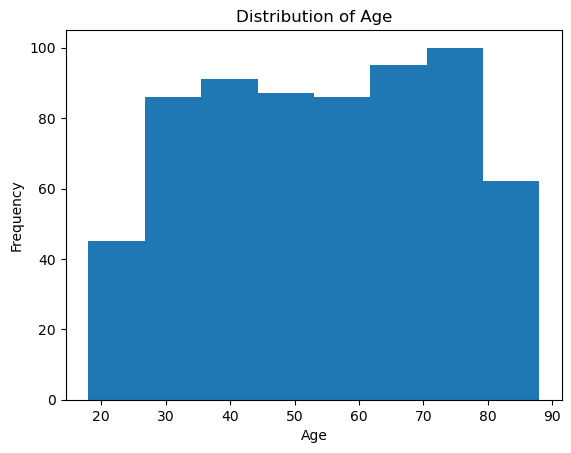

In [6]:
# Looking at age distribution to find the best way to binarize the age variable
plt.hist(y[:,0], bins=8)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

In [10]:
# Age Binning 
    # 0 = 15-24, 1 = 25-34, 2 = 35-44, 3 = 45-54, 4 = 55-64, 5 = 65-74, 6 = 75-84, 7 = 85+
bins = np.array([15, 25, 35, 45, 55, 65, 75, 85])

# Bin the age along the first axis of y
y_binned = np.digitize(y[:,0], bins)

# Use the LabelEncoder to fit and transform the binned ages
le = LabelEncoder()
y_encoded = le.fit_transform(y_binned)

# Recombining the binned age array with participant genders
y_encoded = np.hstack((y_encoded.reshape(-1,1), y[:,1].reshape(-1,1)))

# Check to make sure y_encoded matches y
equal = np.array_equal(y[:, 1], y_encoded[:, 1])

print(f'Genders in y_encoded match y is: {equal}')

Genders in y_encoded match y is: True


## Machine Learning Classification
Uses a logistic regression classifier to find relationship between age and GM, WM, & CSF

In [17]:
## Make Train and Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_encoded,
                                                    stratify=y_encoded,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True
                                                    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((521, 3), (131, 3), (521, 2), (131, 2))

In [ ]:
## Visualizing Stratification of ages & genders


In [ ]:
scaler = StandardScaler() # Should be PCA instead?  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
vectorizer = Vectorizer()

log_reg = LogisticRegression(max_iter=10000, tol=0.1) # Hyperparameters to be tuned


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



clf = Pipeline([('Vectorizer', vectorizer),
                ('Scaler', scaler), # Should be PCA instead?
                ('logistic', log_reg)                                 
                ])

# Cross validating
cv_cv = cross_validate(clf, X_train, y_train, 
                        cv=cv,
                        scoring=scoring,
                        return_train_score=True, # Determines if Training scores are included in .cv_results_
                        n_jobs=5,
                        error_score='raise' # For debugging purposes
                        )

print('Training Classifier')
clf = clf.fit(X_train, y_train)

print('Predicting...')
y_pred = clf.predict(X_test)

print('Scoring...')        
print(classification_report(y_test, y_pred))

# Confusion Matrix Generation and Visualization within the loop -> saved to csv as "[[TN, FN] [FP, TP]]"
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cmd.plot()
plt.title(subject + '_' + str(contr).replace('/', '_') + '_' + c_name)
plt.show()

# Saving CV results to a  DataFrame 
results = pd.DataFrame(cv_cv)



### ML Reference Code

In [ ]:
%%time
%xmode Verbose

scaler = StandardScaler()
vectorizer = Vectorizer()

# Making the crossvalidation to be used in the RandomizedSearch
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for subject in subjects:
    print('\n-------\n\033[;40m' + subject + '\033[m')
    
    # Clearing out the saved data for each participant
    data_table = pd.DataFrame()
    data_table_list = []
    
    for contr, conds in contrasts.items():
        print('-------\n\033[94;40m' + contr + '\033[m')
        subj_epochs = epochs[subject][conds]
        
        # Create a list of labels from event codes mapped to event_id
        event_id_rev = dict(zip(subj_epochs.event_id.values(), subj_epochs.event_id.keys()))
        labels_all = [event_id_rev[e] for e in subj_epochs.events[:, 2]]
        labels_all = pd.DataFrame(labels_all)[0].str.split('/', expand=True).rename(columns={0:'Colour', 1:'Orientation', 2:'Type', 3:'Status', 4:'Location'} )
        label_map = {'Target':1, 'Standard':0}
        labels_all['labels'] = labels_all['Status'].map(label_map)
        labels = labels_all['labels']
        
        # Extract data from subj_epochs and vectorize 
        D = subj_epochs.get_data()
        
        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(D, 
                                                            labels,
                                                            stratify=labels,
                                                            test_size=cl_p['test_size'], 
                                                            random_state=42,
                                                            shuffle=True
                                                           )

        # Classifier Loop
        for c_name, c in classifiers.items():
            print('-------\nRunning classifier: \033[1;91;40m' + c_name + '\033[m')

            # Making the Pipeline
            clf = Pipeline([('Vectorizer', vectorizer),
                             ('Scaler', scaler),
                             (c_name, c)                                 
                             ])

            # Cross validating
            cv_cv = cross_validate(clf, X_train, y_train, 
                                   cv=cv,
                                   scoring=scoring,
                                   return_train_score=True, # Determines if Training scores are included in .cv_results_
                                   n_jobs=5,
                                   error_score='raise' # For debugging purposes
                                   )

            print('Training Classifier')
            clf = clf.fit(X_train, y_train)

            print('Predicting...')
            y_pred = clf.predict(X_test)

            print('Scoring...')        
            print(classification_report(y_test, y_pred))

            # Confusion Matrix Generation and Visualization within the loop -> saved to csv as "[[TN, FN] [FP, TP]]"
            cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
            cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
            cmd.plot()
            plt.title(subject + '_' + str(contr).replace('/', '_') + '_' + c_name)
            plt.show()

            # Saving CV results to a DataFrame 
            results = pd.DataFrame(cv_cv)

            data_table_list.append(pd.DataFrame({'participant_id': subject,
                                              'Condition': contr,
                                              'Classifier': c_name,

                                              # Confusion_matrix saved in format: [[TN, FN] [FP, TP]]
                                              'Confusion_Matrix': str(cm),                                                 

                                              'CV_Train_Bal_Accuracy': results['train_Bal_Acc'].round(3) * 100,
                                              'CV_Test_Bal_Accuracy': results['test_Bal_Acc'].round(3) * 100,
                                              'Test_Bal_Accuracy': round(balanced_accuracy_score(y_test, y_pred), 3) * 100,

                                              'CV_Train_Accuracy': results['train_Acc'].round(3) * 100,
                                              'CV_Test_Accuracy': results['test_Acc'].round(3) * 100,
                                              'Test_Accuracy': round(accuracy_score(y_test, y_pred), 3) * 100, 

                                              'CV_Train_Precision': results['train_Prec'].round(3) * 100,
                                              'CV_Test_Precision': results['test_Prec'].round(3) * 100,                                                
                                              'Test_Precision': round(precision_score(y_test, y_pred, zero_division=0), 3) * 100,    

                                              'CV_Train_Matthews_coef': results['train_Matthews_Coef'].round(3),
                                              'CV_Test_Matthews_coef': results['test_Matthews_Coef'].round(3),
                                              'Matthews_Coef': round(matthews_corrcoef(y_test, y_pred), 3),

                                              'CV_Train_Recall': results['train_Recall'].round(3) * 100,
                                              'CV_Test_Recall': results['test_Recall'].round(3) * 100,
                                              'Test_recall': round(recall_score(y_test, y_pred), 3) * 100,

                                              'CV_Train_Fbeta_0.5': results['train_Fbeta_0.5'].round(3),
                                              'CV_Train_Fbeta_0.5': results['train_Fbeta_0.5'].round(3),
                                              'Fbeta_0.5': round(fbeta_score(y_test, y_pred, beta = 0.5, zero_division=0), 3),

                                              'CV_Train_Fbeta_1.5': results['train_Fbeta_1.5'].round(3),
                                              'CV_Test_Fbeta_1.5': results['test_Fbeta_1.5'].round(3),
                                              'Fbeta_1.5': round(fbeta_score(y_test, y_pred, beta = 1.5, zero_division=0), 3),

                                              'CV_Train_F1': results['train_F1_score'].round(3),
                                              'CV_Test_F1': results['test_F1_score'].round(3),
                                              'F1_score': round(f1_score(y_test, y_pred, zero_division=0), 3),

                                              'CV_Train_ROC_AUC': results['train_ROC'].round(3),
                                              'CV_Test_ROC_AUC': results['test_ROC'].round(3),                                             
                                              'Test_ROC_AUC': round(roc_auc_score(y_test, y_pred), 3),

                                              'Mean Fit Time': results['fit_time'].round(3),
                                              'Mean Score Time': results['score_time'].round(3)
                                             }, index=[0]
                                            )
                               )

    # Saving Data to CSV Per Participant
    data_table = pd.concat(data_table_list)
    data_table.to_csv(f'{str(subject)} new_Data.csv')